In [1]:
!python -V

Python 3.9.24


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/10/26 15:53:54 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/10/26 15:53:54 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1761485494085, experiment_id='1', last_update_time=1761485494085, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

## Load data

Data information :
- `lpep_pickup_datetime` : The date and time when the meter was engaged.
- `lpep_dropoff_datetime` : The date and time when the meter was disengaged.
- `PULocationID` : TLC Taxi Zone in which the taximeter was engaged. 
- `DOlocationID` : TLC Taxi Zone in which the taximeter was disengaged. 
- `trip_distance` : The elapsed trip distance in miles reported by the taximeter.

In [4]:
%time df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
print(df.shape)
df.head(5)

CPU times: user 41.7 ms, sys: 22.8 ms, total: 64.5 ms
Wall time: 192 ms
(76518, 20)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


## Data analysis & transformation

In [5]:
# Data analysis
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [6]:
# Data transformation
df["duration"] = df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]
df["duration"]

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Name: duration, Length: 76518, dtype: timedelta64[us]

In [7]:
td = df.duration.iloc[0]
td

Timedelta('0 days 00:03:56')

In [8]:
td.total_seconds()

236.0

In [9]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
4         0.066667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 76518, dtype: float64

In [10]:
df.duration.describe(percentiles=[0.01, 0.02, 0.05, 0.95, 0.98, 0.99])
# 99% of trips have a duration < 67.16 minutes
# we can keep duration values >= 1 and <= 60

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
1%           0.200000
2%           1.016667
5%           3.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [11]:
# apply filter
df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
# check distribution
df.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Density'>

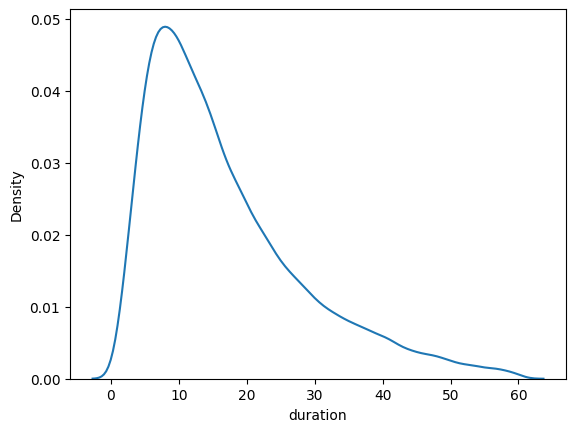

In [12]:
sns.kdeplot(data=df, x="duration")

In [13]:
# selection of variables
df[["PULocationID", "DOLocationID"]].nunique()

PULocationID    250
DOLocationID    256
dtype: int64

In [14]:
df["PULocationID"].value_counts()

PULocationID
74     6555
75     6063
41     4071
42     2683
244    2554
       ... 
27        1
12        1
253       1
187       1
176       1
Name: count, Length: 250, dtype: int64

/tmp/ipykernel_183434/2669459987.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


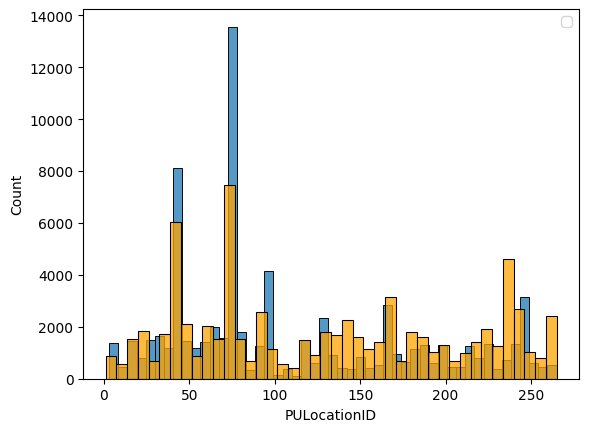

In [15]:
sns.histplot(data=df, x="PULocationID", legend=True)
sns.histplot(data=df, x="DOLocationID", ax=plt.gca(), color="orange", legend=True)
plt.legend()
plt.show()

<Axes: xlabel='trip_distance', ylabel='Density'>

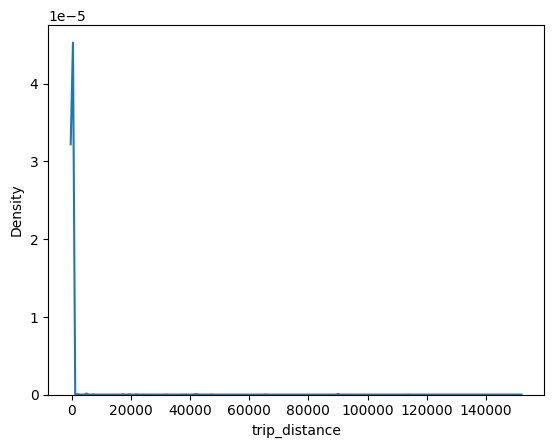

In [16]:
# convert trip_distance unit from miles to km
df.trip_distance = df.trip_distance.apply(lambda x: x / 1.609344)
sns.kdeplot(data=df, x="trip_distance")

In [17]:
df.trip_distance.describe(percentiles=[0.01, 0.02, 0.05, 0.95, 0.98, 0.99])
# variable trip_distance also contains outliers

count     73908.000000
mean         26.127242
std        1216.695964
min           0.000000
1%            0.000000
2%            0.000000
5%            0.310686
50%           1.615565
95%           9.544262
98%          12.247226
99%          14.372316
max      151709.025541
Name: trip_distance, dtype: float64

In [18]:
# apply filter on trip_distance
print(df.shape)
max = np.percentile(df.trip_distance, q=99)
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= max)]
print(df.shape)

(73908, 21)
(71545, 21)


<Axes: xlabel='trip_distance', ylabel='Density'>

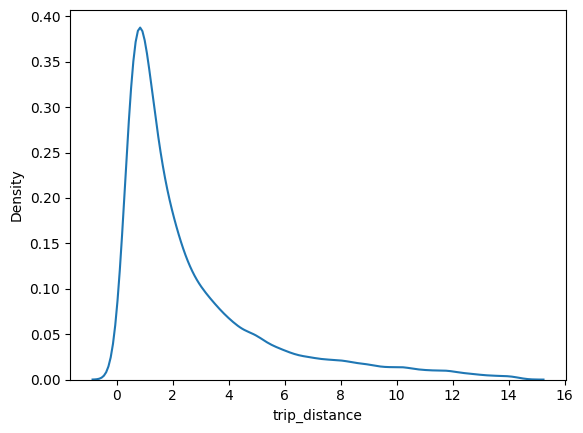

In [19]:
sns.kdeplot(data=df, x="trip_distance")

## Target & feature selection

In [20]:
# feature selection
# categorical variables :
# cat_cols = ["PULocationID", "DOLocationID"]
# since both variables do not really give information separately, we should link them together to represent their interaction
# (kind of like a graph dependancy)
# convert int to str
df[["PULocationID", "DOLocationID"]] = df[["PULocationID", "DOLocationID"]].astype(str)
df["PU_DO"] = df["PULocationID"] + "_" + df["DOLocationID"]
cat_cols = ["PU_DO"]

# numerical variables
num_cols = ["trip_distance"]

In [21]:
# apply one-hot-encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore")

# test on "PULocationID"
Xnew = encoder.fit_transform(df[["PULocationID"]])
Xnew

<71545x248 sparse matrix of type '<class 'numpy.float64'>'
	with 71545 stored elements in Compressed Sparse Row format>

In [22]:
# define target and features
X = df[cat_cols + num_cols]
y = df["duration"]
y_log = np.log(df["duration"])

print(X.shape, y.shape, y_log.shape)

(71545, 2) (71545,) (71545,)


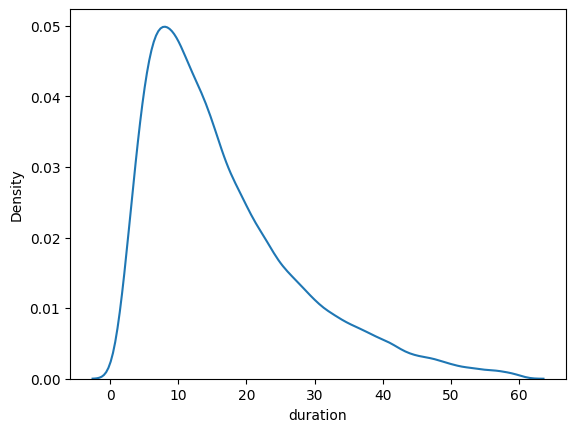

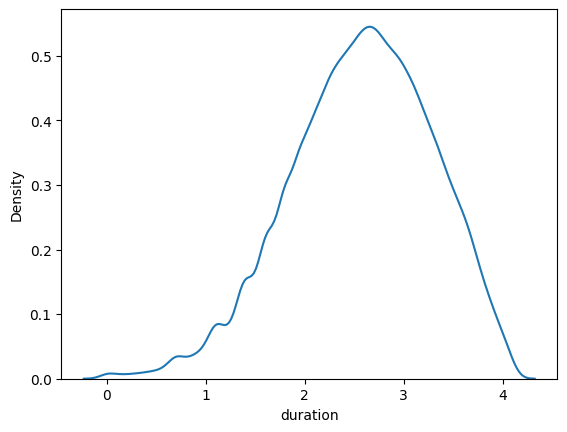

In [23]:
sns.kdeplot(y)
plt.show()

sns.kdeplot(y_log)
plt.show()

In [24]:
# split train/val datasets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, random_state=42
)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(57236, 2) (57236,)
(14309, 2) (14309,)


In [25]:
# define data transformation
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# apply data transformation
# fit_transform on training dataset
# transform on validation dataset

X_train = ct.fit_transform(X_train)
X_valid = ct.transform(X_valid)

print(X_train.shape, X_valid.shape)

(57236, 11392) (14309, 11392)


## Model training & evaluation

In [26]:
# model design

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

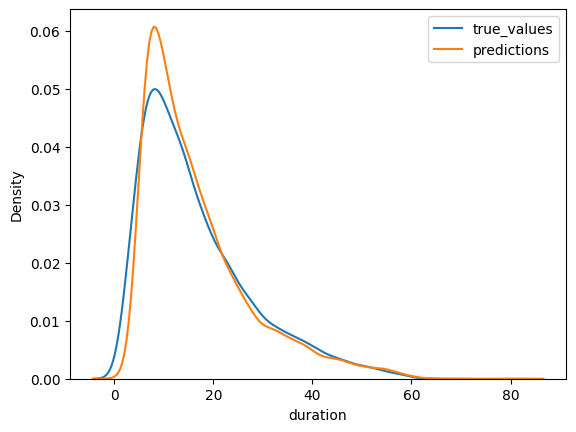

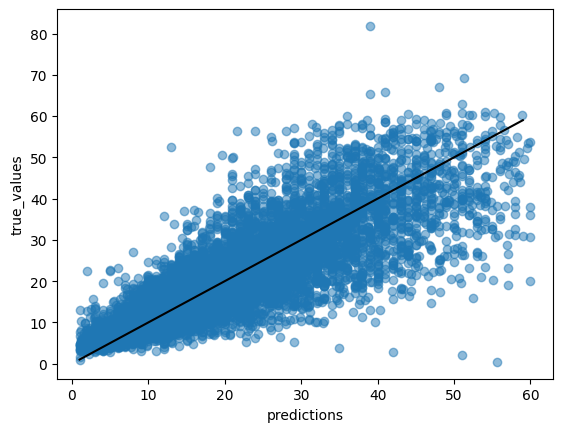

r2 :  0.7348644789629148
rmse:  5.765930288340421


In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

# plt.scatter(y_pred, y_valid)
sns.kdeplot(y_valid, label="true_values")
sns.kdeplot(y_pred, label="predictions")
plt.legend()
plt.show()

# scores
## r2
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.ylabel("true_values")
plt.xlabel("predictions")
# add y=x
sample_y = np.arange(y_valid.min(), y_valid.max())
plt.plot(sample_y, sample_y, color="k")
plt.show()

r2 = r2_score(y_valid, y_pred)

## rmse
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("r2 : ", r2)
print("rmse: ", rmse)

CPU times: user 1min 3s, sys: 65.8 ms, total: 1min 3s
Wall time: 1min 4s


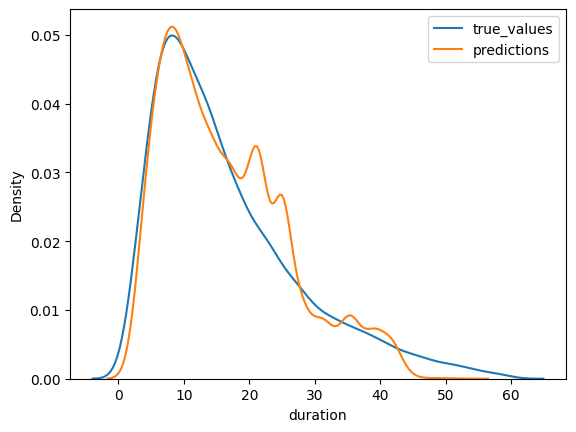

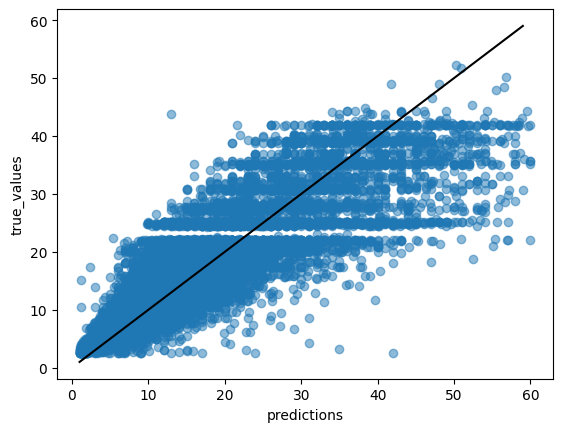

r2 :  0.7411843354306373
rmse:  5.696796535653824


In [28]:
rf = RandomForestRegressor(max_depth=10, n_estimators=500)
%time rf.fit(X_train, y_train)

y_pred = rf.predict(X_valid)

# plt.scatter(y_pred, y_valid)
sns.kdeplot(y_valid, label="true_values")
sns.kdeplot(y_pred, label="predictions")
plt.legend()
plt.show()

# scores
## r2
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.ylabel("true_values")
plt.xlabel("predictions")
# add y=x
sample_y = np.arange(y_valid.min(), y_valid.max())
plt.plot(sample_y, sample_y, color="k")
plt.show()

r2 = r2_score(y_valid, y_pred)

## rmse
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("r2 : ", r2)
print("rmse: ", rmse)

## Tracking experiments with MLFlow

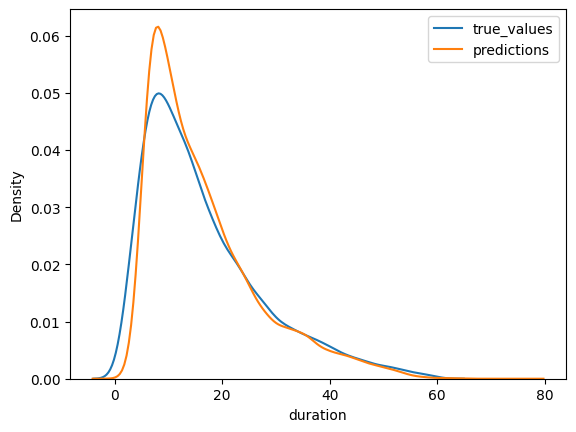

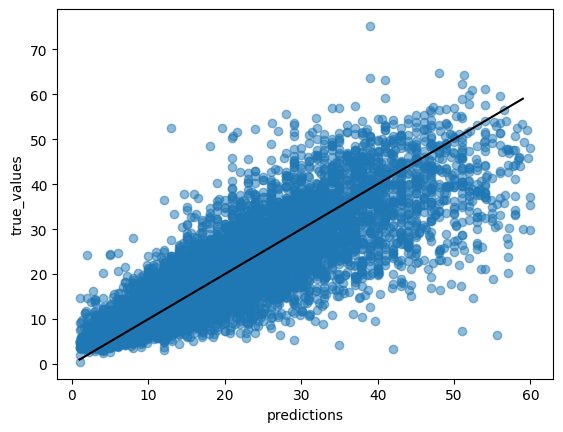

r2 :  0.7482981370065913
rmse:  5.617960025328431


In [29]:
## level 1 : tracking manual runs

with mlflow.start_run():
    mlflow.set_tag("developer", "elizabeth")
    mlflow.set_tag("git_branch", "main")
    mlflow.set_tag(
        "git_commit",
        "a6923d5",
    )

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("train_size", 0.8)

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_valid)

    # plt.scatter(y_pred, y_valid)
    sns.kdeplot(y_valid, label="true_values")
    sns.kdeplot(y_pred, label="predictions")
    plt.legend()
    plt.show()

    # scores
    ## r2
    plt.scatter(y_valid, y_pred, alpha=0.5)
    plt.ylabel("true_values")
    plt.xlabel("predictions")
    # add y=x
    sample_y = np.arange(y_valid.min(), y_valid.max())
    plt.plot(sample_y, sample_y, color="k")
    plt.show()

    r2 = r2_score(y_valid, y_pred)
    mlflow.log_metric("r2_score", r2)

    ## rmse
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print("r2 : ", r2)
    print("rmse: ", rmse)
    mlflow.log_metric("rmse", rmse)

In [ ]:
## level 2 : tracking hyperparametrization of models (ex: randomforest)

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ParameterGrid,
)

# define parameter grid
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2'],
    #    'bootstrap': [True, False]
}

for params in ParameterGrid(param_grid):
    # define the model
    rf = RandomForestRegressor(**params, random_state=42)
    rf.fit(X_train, y_train)  # train on your training data

    y_pred = rf.predict(X_valid)  # predict on validation data
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    r2 = r2_score(y_valid, y_pred)

    best_rmse = float("inf")
    best_rf = None

    # Log metrics and parameters in MLflow for each set of hyperparameter
    with mlflow.start_run(run_name="RF_GridSearchCV", nested=True):
        mlflow.set_tag("developer", "elizabeth")
        mlflow.set_tag("git_branch", "main")
        mlflow.set_tag(
            "git_commit",
            "a6923d5",
        )
        mlflow.set_tag("model", "randomforest")
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
        mlflow.log_param("train_size", 0.8)
        mlflow.log_params(params)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2_score", r2)

    # save the best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_rf = rf

## Model & transformers save parameters

In [ ]:
import pickle

In [ ]:
%%time 
# Save models
# here we only save the models that were changed thanks to the experiment tracking
with open("models/lr.bin", "wb") as f_out:
    pickle.dump((ct, lr), f_out)

with open("models/best_rf.bin", "wb") as f_out:
    pickle.dump((ct, best_rf), f_out)